In [1]:

import sys

import seaborn as sns
import numpy as np
import random
from time import time
import pickle
import os 


import re
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

if 'models' not in os.listdir(): 
    os.mkdir('models')

In [2]:
a = pd.read_csv('../data_collection/data/art_info1.csv')
a.head(1)

,Unnamed: 0,tweet_id,text,top_image,title,authors,summary,keywords
0,0,1097372619848986625,A kindergarten boy’s behavior could predict hi...,https://static01.nyt.com/images/2016/09/14/wel...,Behavior at Age 6 May Predict Adult Income,['Nicholas Bakalar'],A kindergarten boy’s behavior could predict hi...,"['boys', 'income', 'inattention', 'age', 'beha..."


In [3]:
a.drop(['Unnamed: 0'], axis =1, inplace = True)
a.head(6)

,tweet_id,text,top_image,title,authors,summary,keywords
0,1097372619848986625,A kindergarten boy’s behavior could predict hi...,https://static01.nyt.com/images/2016/09/14/wel...,Behavior at Age 6 May Predict Adult Income,['Nicholas Bakalar'],A kindergarten boy’s behavior could predict hi...,"['boys', 'income', 'inattention', 'age', 'beha..."
1,1097368941842837506,"In more than 14 years of roaming Mars, NASA’s ...",https://static01.nyt.com/images/2019/02/15/sci...,Photos From the Opportunity Rover’s Mission on...,['Kenneth Chang'],"In more than 14 years of roaming Mars, NASA’s ...","['mission', 'rovers', 'mars', 'opportunity', '..."
2,1097364848890007552,Studies show that at a normal body weight — ge...,https://static01.nyt.com/images/2019/02/19/wel...,Why Do South Asians Have Such High Rates of He...,['Anahad O Connor'],Heart risks tended to be greatest in South Asi...,"['masala', 'disease', 'rates', 'high', 'health..."
3,1097359831034486785,"For Elisa, interviewing Hays has been a frustr...",https://static01.nyt.com/images/2019/02/18/art...,"‘True Detective’ Season 3, Episode 7: Missing ...",['Scott Tobias'],The one-eyed man whom they had originally ques...,"['true', 'discover', 'missing', 'lucy', '1990'..."
4,1097355297138581507,The hiring went off like a sonic boom in Holly...,https://static01.nyt.com/images/2019/02/18/bus...,"In Bid to Conquer Oscars, Netflix Mobilizes Sa...",['Brooks Barnes'],“Awards Landscape Rocked as Netflix Poaches Le...,"['savvy', 'studios', 'conquer', 'roma', 'holly..."
5,1097351280505339909,Do you think the situation taught you to carry...,https://static01.nyt.com/images/2019/02/18/art...,"21 Savage on ICE Detention, the Grammys and Hi...",['Jon Caramanica'],"If they said, “Hey, you could start your life ...","['gonna', 'wouldnt', 'sure', 'grammys', 'aint'..."


# Text PreProcessing:

The first step is to process each article's text and convert it into a list of useful words.

In [5]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
texts = []
bigrams = []

#iterating over the text of each article
for text in a.text:
    

    doc = str(text).replace("\n"," ") # removing line separators 
    doc = doc.replace("\'","")# removing line separators 

    doc = gensim.utils.simple_preprocess(doc)

    wordnet_lemmatizer = WordNetLemmatizer()
    doc = [wordnet_lemmatizer.lemmatize(word) for word in doc]
    doc = [wordnet_lemmatizer.lemmatize(word,pos='v') for word in doc]

    letters = ["a","b","c","d","e","f","g","h","i","j","k","l","m","n","o","p","q","r","s","t","u","v","w","x","y","z"]
    other = ["wa","ha","one","two","id","re","http","com","mr","image","photo","caption","don","sen","pic","co",
             "source","watch","play","duration","video","momentjs","getty","images","newsletter", "story", "go", "like", "say",
             "will", "just", "today", "can", "year", "make", "view", "read", 'would', 'also']  #words outside of stopwords
    doc = [word for word in doc if not word in (stop_words+letters+other)]
    
    texts.append(doc)

a['cleaned_text'] = texts
a.head(1)

,tweet_id,text,top_image,title,authors,summary,keywords,cleaned_text
0,1097372619848986625,A kindergarten boy’s behavior could predict hi...,https://static01.nyt.com/images/2016/09/14/wel...,Behavior at Age 6 May Predict Adult Income,['Nicholas Bakalar'],A kindergarten boy’s behavior could predict hi...,"['boys', 'income', 'inattention', 'age', 'beha...","[kindergarten, boy, behavior, could, predict, ..."


In [6]:
texts = a['cleaned_text']

In [16]:
import os
directory = 'pickled_files'
if not directory in os.listdir():
    os.mkdir(directory)

In [23]:
import pickle 
import random 
random.seed(42)
train_set = random.sample(list(range(0,len(texts))),len(texts)-1000)
test_set = [x for x in list(range(0,len(texts))) if x not in train_set]

train_texts = [texts[i] for i in train_set]
test_texts = [texts[i] for i in test_set]

pickle.dump([train_set,test_set,train_texts,test_texts],open('pickled_files/pub_articles_train_test_sets.pkl','wb'))

In [24]:
train_Set, test_set, train_texts, test_texts = pickle.load(open('pickled_files/pub_articles_train_test_sets.pkl','rb'))

Next we create the corpus, which converts each document into a list of tuples in the form of (word id, word freq in doc) 

In [53]:
#Create Term-Frequency for each article and add them to a list (corpus). 
corpus = [dictionary.doc2bow(text) for text in train_texts]

In [56]:
len(corpus), len(train_texts)

(1434, 1434)

Gensim creates a unique id for each word in the document. Each id(word) is used as key for the dictionary with the value for the key set to the frequency of the word to appear in that document. The produced corpus shown below (line 1) is a mapping of (word_id, word_frequency). This is used as the input by the LDA model.


In [44]:
#print the (word_id, word_frequency) for each word in article 1 and 2
print('\n', corpus[0])
print('\n', corpus[1])

[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 5), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 3), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 3), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 3), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 2), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 2), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 2), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1)]

 [(10, 1), (16, 1), (19, 2), (27, 1), (31, 1), (52, 1), (77, 3), (78, 2), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 4), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 2), (104, 2), (1

In [41]:
# To see what word a given id corresponds to, pass the id as a key to the dictionary.
print(dictionary[0], dictionary[10], dictionary[76])

add call write


In [45]:
# Human readable format of the first article in corpus (term-frequency)
print('\n', [(dictionary[id], freq) for id, freq in corpus[0]])
print('\n', [(dictionary[id], freq) for id, freq in corpus[1]])


 [('add', 1), ('affair', 1), ('association', 2), ('baker', 1), ('bandwidth', 1), ('basis', 1), ('become', 1), ('brexit', 5), ('business', 2), ('busy', 1), ('call', 1), ('catastrophe', 1), ('catastrophic', 1), ('chain', 1), ('consultation', 1), ('continue', 1), ('could', 1), ('deal', 3), ('deliver', 1), ('department', 2), ('dinner', 1), ('email', 1), ('engage', 1), ('environment', 1), ('farmer', 1), ('focus', 1), ('food', 3), ('friday', 1), ('gove', 1), ('green', 1), ('impact', 1), ('include', 1), ('initiative', 1), ('intensify', 1), ('issue', 3), ('letter', 1), ('london', 1), ('matter', 1), ('meet', 1), ('member', 1), ('michael', 1), ('mince', 1), ('mitigate', 1), ('neither', 1), ('non', 1), ('organizational', 1), ('people', 1), ('physical', 1), ('plan', 2), ('plastic', 1), ('plate', 1), ('policy', 1), ('prepare', 1), ('priority', 1), ('producer', 1), ('properly', 1), ('reduce', 1), ('relate', 1), ('representative', 1), ('resource', 1), ('respond', 2), ('rural', 1), ('secretary', 1), 

# Bag of Words + LDA

In [113]:
dictionary = corpora.Dictionary(texts)
pickle.dump(dictionary,open('pickled_files/pub_ldamodels_bow_dictionary.pkl','wb'))

In [114]:
corpus = [dictionary.doc2bow(text) for text in texts]
topic_nums = [2, 4, 6, 8, 10]
ldamodels_bow = {}
for i in topicnums:
    random.seed(42)
    %time ldamodels_bow[i] = models.ldamodel.LdaModel(corpus,num_topics=i,id2word=dictionary)
    ldamodels_bow[i].save('models/ldamodels_bow_'+str(i)+'.lda')

CPU times: user 438 ms, sys: 883 µs, total: 439 ms
Wall time: 439 ms
CPU times: user 2.09 s, sys: 8.53 ms, total: 2.09 s
Wall time: 2.1 s
CPU times: user 2.08 s, sys: 7.12 ms, total: 2.09 s
Wall time: 2.09 s
CPU times: user 2.17 s, sys: 8.91 ms, total: 2.18 s
Wall time: 2.19 s
CPU times: user 2.07 s, sys: 6.67 ms, total: 2.07 s
Wall time: 2.07 s
CPU times: user 3.09 s, sys: 188 ms, total: 3.28 s
Wall time: 2.28 s
CPU times: user 3.16 s, sys: 171 ms, total: 3.33 s
Wall time: 2.29 s
CPU times: user 3.45 s, sys: 219 ms, total: 3.67 s
Wall time: 2.09 s
CPU times: user 3.6 s, sys: 251 ms, total: 3.85 s
Wall time: 2.12 s
CPU times: user 3.6 s, sys: 248 ms, total: 3.85 s
Wall time: 2.13 s


### Evaluation

LDA topic modeling is an unsupervised task and thus quite challenging to evaluate. 
In this section, we take a round about way to assess our model. 
The process involves splitting each document into two parts, and checking that 
1) Topics of the first half are similar to topics of the second half 
2) Halves of different documents are mostly dissimilar. 

In [115]:
def intra_inter_bow(lda_model, dictionary, test_docs, num_pairs=10000):
    
    # Split each test document into two halves and compute topics for each half
    part1 = [lda_model[dictionary.doc2bow(tokens[:int(len(tokens)/2)])] for tokens in test_docs]
    part2 = [lda_model[dictionary.doc2bow(tokens[int(len(tokens)/2):])] for tokens in test_docs]   
    
    # Compute topic distribution similarities using cosine similarity
    
    #print("Average cosine similarity between corresponding parts (higher is better):")
    corresp_parts = np.mean([gensim.matutils.cossim(p1, p2) for p1, p2 in zip(part1, part2)])

    #print("Average cosine similarity between 10,000 random parts (lower is better):")    
    random.seed(42)
    random_pairs = np.random.randint(0, len(test_docs), size=(num_pairs, 2))
    random_parts = np.mean([gensim.matutils.cossim(part1[i[0]], part2[i[1]]) for i in random_pairs])
    
    return corresp_parts, random_parts


In [116]:
ldamodels_eval = {}
for i in topicnums:
    lda_model = models.ldamodel.LdaModel.load('models/ldamodels_bow_'+str(i)+'.lda')
    ldamodels_eval[i] = intra_inter_bow(lda_model, dictionary, test_texts)
    
pickle.dump(ldamodels_eval,open('pickled_files/pub_ldamodels_bow_eval.pkl','wb'))

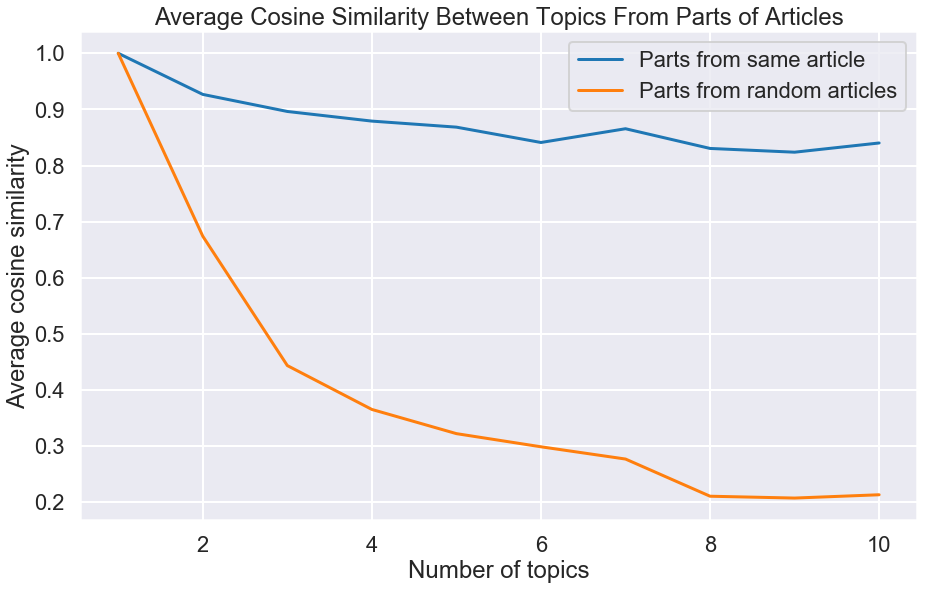

In [117]:


ldamodels_eval = pickle.load(open('pickled_files/pub_ldamodels_bow_eval.pkl','rb'))
corresp_parts = [ldamodels_eval[i][0] for i in topicnums]
random_parts = [ldamodels_eval[i][1] for i in topicnums]
sns.set_context("poster")
with sns.axes_style("darkgrid"):
    x = topicnums
    y1 = corresp_parts
    y2 = random_parts
    plt.figure(figsize = (15, 9))
    plt.plot(x,y1,label='Parts from same article')
    plt.plot(x,y2,label='Parts from random articles')
    plt.xlabel('Number of topics')
    plt.ylabel('Average cosine similarity') 
    plt.title('Average Cosine Similarity Between Topics From Parts of Articles')
    plt.legend()    
    plt.show()


In [118]:

lda_topics = {}
for i in topicnums:
    lda_model = models.ldamodel.LdaModel.load('models/ldamodels_bow_'+str(i)+'.lda')
    #get a list of tuplle with the first element as topic number and the second element as key words of each topic 
    # with their probability disttribution all as a string. 
    # example tuple for topic 0: (0, '0.001*"trump" + 0.001*"president" + 0.001*"state" + 0.001*"people")
    
    lda_topics_string = lda_model.show_topics(i)
    
    #parse the second element to get  only the keywords without the probability scores attached as a list of words
    # example list for topic 0 : ['trump', 'president', 'state', 'people']
    
    for topic in lda_topics_string: 
        lda_topics[i] = "".join([c if c.isalpha() else " " for c in topic[1]]).split()

pickle.dump(lda_topics,open('pickled_files/pub_lda_bow_topics.pkl','wb'))


### Chosing the number of topics 

The number of topics was chosen by trying to achieve a diverse topic coverage without having too many topics. The diversity of topics can be evaluated by the average Jaccard similarity between topics. High Jaccard similarity indicates strong overlap and less diversity between topics, while low similarity means the topics are more diverse and have a better coverage among all the aspects in the articles.

In [110]:
def jaccard_similarity(query, document):
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    return float(len(intersection))/float(len(union))

In [119]:
da_stability = {}
for i in range(0,len(topicnums)-1):
    jacc_sims = []
    for t1,topic1 in enumerate(lda_topics[topicnums[i]]):
        sims = []
        for t2,topic2 in enumerate(lda_topics[topicnums[i+1]]):
            sims.append(jaccard_similarity(topic1,topic2))    
        jacc_sims.append(sims)    
    lda_stability[topicnums[i]] = jacc_sims
    
pickle.dump(lda_stability,open('pickled_files/pub_lda_bow_stability.pkl','wb'))

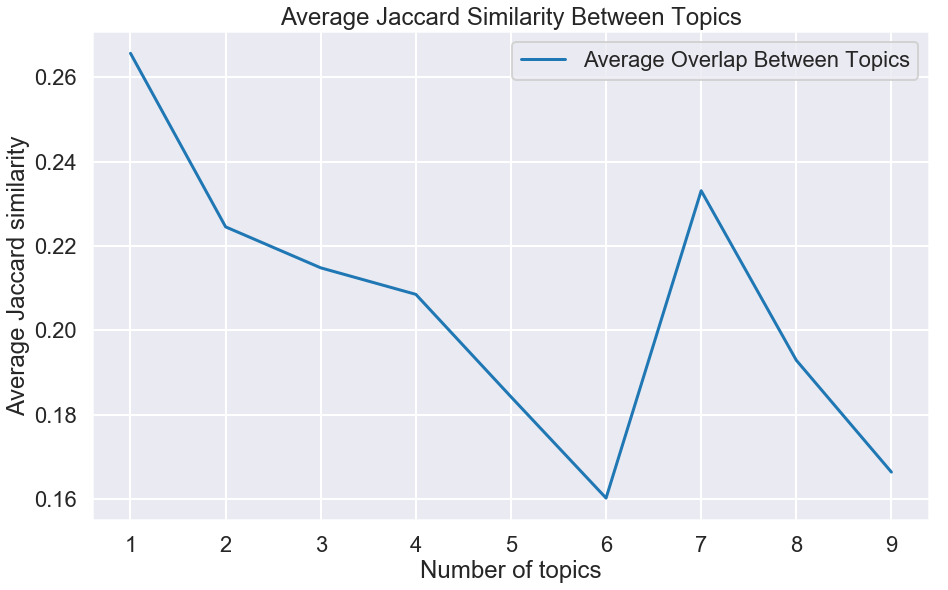

In [120]:


lda_stability = pickle.load(open('pickled_files/pub_lda_bow_stability.pkl','rb'))
mean_stability = [np.array(lda_stability[i]).mean() for i in topicnums[:-1]]

with sns.axes_style("darkgrid"):
    x = topicnums[:-1]
    y = mean_stability
    plt.figure(figsize = (15, 9))
    plt.plot(x,y,label='Average Overlap Between Topics')
    plt.xlabel('Number of topics')
    plt.ylabel('Average Jaccard similarity')   
    plt.title('Average Jaccard Similarity Between Topics')
    plt.legend()    
    plt.show()


In [130]:


coherence = {}
for i in topicnums:
    lda_model = models.ldamodel.LdaModel.load('models/ldamodels_bow_'+str(i)+'.lda')
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence[i] = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence[i])



Coherence Score:  0.24938755944856922

Coherence Score:  0.25153165899282726

Coherence Score:  0.32623137317410045

Coherence Score:  0.3267868203404659

Coherence Score:  0.2980794078574718

Coherence Score:  0.3039304399783988

Coherence Score:  0.30902696854178024

Coherence Score:  0.3059928295296648

Coherence Score:  0.3102211056621955

Coherence Score:  0.31517957710083755


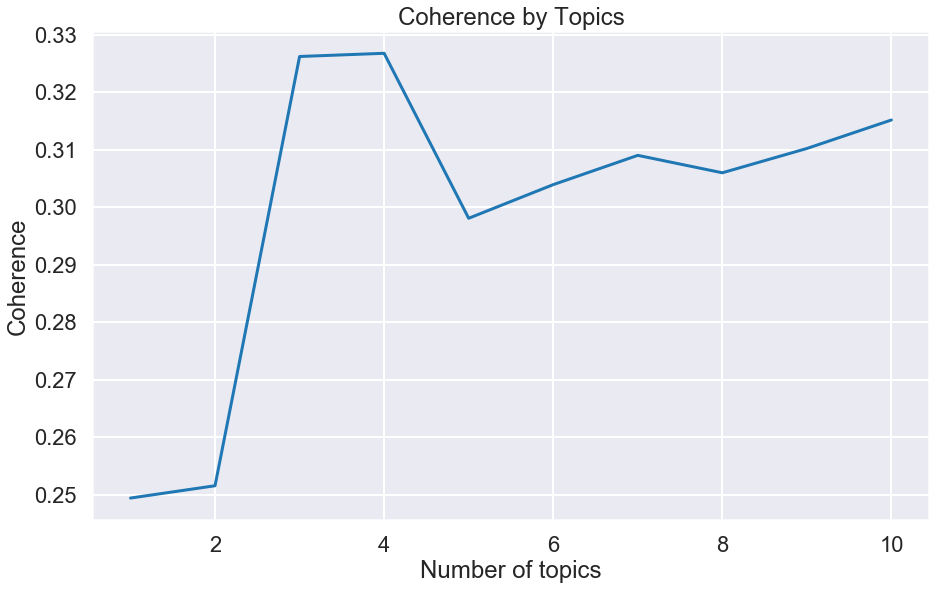

In [129]:
with sns.axes_style("darkgrid"):
    x = topicnums
    y = coherence.values()
    plt.figure(figsize = (15, 9))
    plt.plot(x,y,label='Coherence by Topics')
    plt.xlabel('Number of topics')
    plt.ylabel('Coherence')   
    plt.title('Coherence by Topics')  
    plt.show()

In [131]:
num_topics = 5
lda_model_5 = models.ldamodel.LdaModel.load('models/ldamodels_bow_'+str(num_topics)+'.lda')
doc_dict = pickle.load(open('pickled_files/pub_ldamodels_bow_dictionary.pkl','rb'))

In [132]:
lda_model_5.print_topics()

[(0,
  '0.006*"time" + 0.005*"border" + 0.005*"trump" + 0.004*"state" + 0.004*"new" + 0.004*"get" + 0.004*"people" + 0.004*"work" + 0.004*"mexico" + 0.003*"take"'),
 (1,
  '0.005*"time" + 0.005*"dam" + 0.004*"new" + 0.004*"day" + 0.004*"get" + 0.003*"know" + 0.003*"people" + 0.003*"life" + 0.003*"work" + 0.003*"find"'),
 (2,
  '0.007*"people" + 0.007*"woman" + 0.004*"new" + 0.004*"school" + 0.004*"first" + 0.003*"time" + 0.003*"american" + 0.003*"president" + 0.003*"life" + 0.003*"tell"'),
 (3,
  '0.009*"trump" + 0.006*"new" + 0.006*"president" + 0.005*"people" + 0.004*"time" + 0.004*"know" + 0.004*"get" + 0.004*"come" + 0.004*"work" + 0.004*"first"'),
 (4,
  '0.006*"new" + 0.006*"state" + 0.004*"trump" + 0.004*"government" + 0.004*"people" + 0.004*"president" + 0.004*"time" + 0.003*"michael" + 0.003*"day" + 0.003*"know"')]

# Optimal Model

Based on the above analysis we see the following: 
1. average jaccard similarity between the topics continue to decrease until number of topic reaches 6 
2. Coherence score is the higest at 3/4 
3. I decided to use a number of topic that is between 6 and 3 and picked 5 for the purpose of the project


In [133]:
num_topics = 5
lda_model = models.ldamodel.LdaModel.load('models/ldamodels_bow_'+str(num_topics)+'.lda')
doc_dict = pickle.load(open('pickled_files/pub_ldamodels_bow_dictionary.pkl','rb'))

In [134]:
lda_model.print_topics()

[(0,
  '0.006*"time" + 0.005*"border" + 0.005*"trump" + 0.004*"state" + 0.004*"new" + 0.004*"get" + 0.004*"people" + 0.004*"work" + 0.004*"mexico" + 0.003*"take"'),
 (1,
  '0.005*"time" + 0.005*"dam" + 0.004*"new" + 0.004*"day" + 0.004*"get" + 0.003*"know" + 0.003*"people" + 0.003*"life" + 0.003*"work" + 0.003*"find"'),
 (2,
  '0.007*"people" + 0.007*"woman" + 0.004*"new" + 0.004*"school" + 0.004*"first" + 0.003*"time" + 0.003*"american" + 0.003*"president" + 0.003*"life" + 0.003*"tell"'),
 (3,
  '0.009*"trump" + 0.006*"new" + 0.006*"president" + 0.005*"people" + 0.004*"time" + 0.004*"know" + 0.004*"get" + 0.004*"come" + 0.004*"work" + 0.004*"first"'),
 (4,
  '0.006*"new" + 0.006*"state" + 0.004*"trump" + 0.004*"government" + 0.004*"people" + 0.004*"president" + 0.004*"time" + 0.003*"michael" + 0.003*"day" + 0.003*"know"')]

In [135]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.027367 -0.030381       1        1  26.641569
2     -0.052177 -0.025864       2        1  21.053938
0      0.028188  0.021551       3        1  18.699400
3      0.017487 -0.010472       4        1  17.144545
1     -0.020865  0.045167       5        1  16.460552, topic_info=      Category         Freq            Term        Total  loglift  logprob
term                                                                      
2695   Default   758.000000          border   758.000000  30.0000  30.0000
346    Default  1043.000000           woman  1043.000000  29.0000  29.0000
1826   Default  1871.000000           trump  1871.000000  28.0000  28.0000
2784   Default   642.000000             dam   642.000000  27.0000  27.0000
9745   Default   321.000000         rashida   321.000000  26.0000  26.0000
9746   Default   312.000000           tlaib   312.000000  25.0000  25.0000
3134   Default   444.000000          mexico   444.000000  24.0000  24.0000
3282   Default   551.000000        shutdown   551.000000  23.0000  23.0000
74     Default   620.000000          school   620.000000  22.0000  22.0000
14152  Default   157.000000         eclipse   157.000000  21.0000  21.0000
1786   Default   301.000000       elizabeth   301.000000  20.0000  20.0000
1976   Default   181.000000            moon   181.000000  19.0000  19.0000
3382   Default   195.000000           texas   195.000000  18.0000  18.0000
639    Default   787.000000            life   787.000000  17.0000  17.0000
18284  Default    84.000000          lapita    84.000000  16.0000  16.0000
1108   Default   454.000000          police   454.000000  15.0000  15.0000
1254   Default   248.000000        catholic   248.000000  14.0000  14.0000
85     Default   203.000000             tax   203.000000  13.0000  13.0000
667    Default  1870.000000            time  1870.000000  12.0000  12.0000
1542   Default  1499.000000       president  1499.000000  11.0000  11.0000
6543   Default   235.000000          pelosi   235.000000  10.0000  10.0000
3342   Default   132.000000          asylum   132.000000   9.0000   9.0000
9919   Default   137.000000        phillips   137.000000   8.0000   8.0000
3841   Default    64.000000           skull    64.000000   7.0000   7.0000
2325   Default   199.000000           brief   199.000000   6.0000   6.0000
201    Default   332.000000              dr   332.000000   5.0000   5.0000
3361   Default   219.000000         migrant   219.000000   4.0000   4.0000
2688   Default   593.000000            wall   593.000000   3.0000   3.0000
234    Default   823.000000           house   823.000000   2.0000   2.0000
303    Default   398.000000  representative   398.000000   1.0000   1.0000
...        ...          ...             ...          ...      ...      ...
604     Topic5    65.717049           total   160.542145   0.9110  -6.9454
667     Topic5   336.837006            time  1870.089111   0.0901  -5.3112
26      Topic5   201.052994            find   862.751038   0.3476  -5.8272
1684    Topic5    71.998360         earlier   186.327179   0.8533  -6.8541
460     Topic5   189.292343           start   835.053345   0.3200  -5.8875
110     Topic5   256.149170             get  1386.449341   0.1155  -5.5850
739     Topic5   233.104050            know  1282.425171   0.0992  -5.6793
116     Topic5   155.895447            look   688.304871   0.3192  -6.0816
55      Topic5   289.813263             new  2019.298584  -0.1371  -5.4615
181     Topic5   121.765099           child   453.032532   0.4903  -6.3287
450     Topic5   173.906921           right   865.784912   0.1991  -5.9722
174     Topic5   179.242950            call   923.863037   0.1644  -5.9420
96      Topic5   176.301849            back   898.553101   0.1756  -5.9586
475     Topic5   206.048325            work  1203.832520   0.0390  -5.8026
15      Topic5   189.322021           could  1036.9466

In [139]:
pyLDAvis.save_html(vis, 'topics.html')

In [140]:
lda_topics = lda_model.show_topics(num_topics)
lda_topics_words = ["".join([c if c.isalpha() else " " for c in topic[1]]).split() for topic in lda_topics]
lda_topics_disp = [("topic "+str(i)+": ")+" ".join(topic) for i,topic in enumerate(lda_topics_words)]
lda_topics_disp
pickle.dump(lda_topics_disp,open('pub_lda_bow_topics.pkl','wb'))

In [141]:
len(corpus)

2434

In [142]:
# the corpus lists for each article a list of tuples, where the first element is a topic and the second is the 
# the  probability of that article falling in that topic

#checking the number of articles 
print(len(list(lda_model[corpus])), a.shape[0])

#Looking at the corpus
list(lda_model[corpus])[:10]

2434 2434


[[(1, 0.44804087), (2, 0.5470154)],
 [(3, 0.5804074), (4, 0.41045392)],
 [(0, 0.34920666), (1, 0.029351428), (2, 0.23813823), (4, 0.38269305)],
 [(0, 0.01712639), (1, 0.835523), (2, 0.12352091), (3, 0.022716986)],
 [(2, 0.1943974), (4, 0.8026157)],
 [(0, 0.30985105), (1, 0.09895173), (2, 0.35787174), (3, 0.22902173)],
 [(1, 0.01872882), (2, 0.9444361), (3, 0.035068505)],
 [(0, 0.9497779), (1, 0.04082474)],
 [(1, 0.99301815)],
 [(1, 0.35039237), (3, 0.06428124), (4, 0.581815)]]

In [143]:
# For each article  pick the topic with the highest probabiliy

topic = []
count = []
for i, r in enumerate(lda_model[corpus]):
    sorted_by_second = sorted(r, key=lambda tup: tup[1], reverse = True)
    count.append(len(r))
    topic.append(r[0][0])
   

In [144]:
topic[:7]

[1, 3, 0, 0, 2, 0, 1]

In [145]:
#adding the topic and the count columns

a['topic'] = topic
a['count'] = count

In [146]:
a.topic.unique()

array([1, 3, 0, 2, 4])

In [154]:
a.shape

(2434, 10)

In [152]:
a.head()

,tweet_id,text,top_image,title,authors,summary,keywords,cleaned_text,topic,count
0,1097372619848986625,A kindergarten boy’s behavior could predict hi...,https://static01.nyt.com/images/2016/09/14/wel...,Behavior at Age 6 May Predict Adult Income,['Nicholas Bakalar'],A kindergarten boy’s behavior could predict hi...,"['boys', 'income', 'inattention', 'age', 'beha...","[kindergarten, boy, behavior, could, predict, ...",1,2
1,1097368941842837506,"In more than 14 years of roaming Mars, NASA’s ...",https://static01.nyt.com/images/2019/02/15/sci...,Photos From the Opportunity Rover’s Mission on...,['Kenneth Chang'],"In more than 14 years of roaming Mars, NASA’s ...","['mission', 'rovers', 'mars', 'opportunity', '...","[roam, mar, nasa, opportunity, rover, take, pi...",3,2
2,1097364848890007552,Studies show that at a normal body weight — ge...,https://static01.nyt.com/images/2019/02/19/wel...,Why Do South Asians Have Such High Rates of He...,['Anahad O Connor'],Heart risks tended to be greatest in South Asi...,"['masala', 'disease', 'rates', 'high', 'health...","[study, show, normal, body, weight, generally,...",0,4
3,1097359831034486785,"For Elisa, interviewing Hays has been a frustr...",https://static01.nyt.com/images/2019/02/18/art...,"‘True Detective’ Season 3, Episode 7: Missing ...",['Scott Tobias'],The one-eyed man whom they had originally ques...,"['true', 'discover', 'missing', 'lucy', '1990'...","[elisa, interview, hay, frustrate, act, excava...",0,4
4,1097355297138581507,The hiring went off like a sonic boom in Holly...,https://static01.nyt.com/images/2019/02/18/bus...,"In Bid to Conquer Oscars, Netflix Mobilizes Sa...",['Brooks Barnes'],“Awards Landscape Rocked as Netflix Poaches Le...,"['savvy', 'studios', 'conquer', 'roma', 'holly...","[hire, sonic, boom, hollywood, reverberate, hi...",2,2


In [112]:
a = pd.merge(a, art, how = 'outer', on = ['tweet_id'])
print(a1.shape)
a.head()

(2434, 9)


,tweet_id,text,top_image,title,authors,summary,keywords,cleaned_text,topic
0,1097372619848986625,A kindergarten boy’s behavior could predict hi...,https://static01.nyt.com/images/2016/09/14/wel...,Behavior at Age 6 May Predict Adult Income,['Nicholas Bakalar'],A kindergarten boy’s behavior could predict hi...,"['boys', 'income', 'inattention', 'age', 'beha...","[kindergarten, boy, behavior, could, predict, ...",0
1,1097368941842837506,"In more than 14 years of roaming Mars, NASA’s ...",https://static01.nyt.com/images/2019/02/15/sci...,Photos From the Opportunity Rover’s Mission on...,['Kenneth Chang'],"In more than 14 years of roaming Mars, NASA’s ...","['mission', 'rovers', 'mars', 'opportunity', '...","[roam, mar, nasa, opportunity, rover, take, pi...",0
2,1097364848890007552,Studies show that at a normal body weight — ge...,https://static01.nyt.com/images/2019/02/19/wel...,Why Do South Asians Have Such High Rates of He...,['Anahad O Connor'],Heart risks tended to be greatest in South Asi...,"['masala', 'disease', 'rates', 'high', 'health...","[study, show, normal, body, weight, generally,...",0
3,1097359831034486785,"For Elisa, interviewing Hays has been a frustr...",https://static01.nyt.com/images/2019/02/18/art...,"‘True Detective’ Season 3, Episode 7: Missing ...",['Scott Tobias'],The one-eyed man whom they had originally ques...,"['true', 'discover', 'missing', 'lucy', '1990'...","[elisa, interview, hay, frustrate, act, excava...",0
4,1097355297138581507,The hiring went off like a sonic boom in Holly...,https://static01.nyt.com/images/2019/02/18/bus...,"In Bid to Conquer Oscars, Netflix Mobilizes Sa...",['Brooks Barnes'],“Awards Landscape Rocked as Netflix Poaches Le...,"['savvy', 'studios', 'conquer', 'roma', 'holly...","[hire, sonic, boom, hollywood, reverberate, hi...",1


In [153]:
a.to_csv('../data_collection/data/art_info_w_topic.csv')

Text(0.5,1,'Articles in Topic')

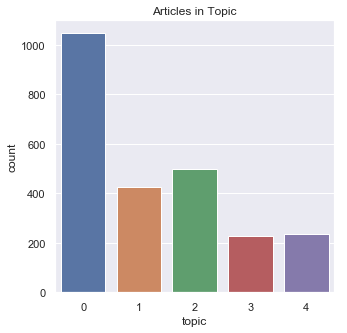

In [155]:
import seaborn as sns
import matplotlib.pyplot as plt
figure = plt.figure(figsize = (5, 5))
sns.set(style="darkgrid")

ax = sns.countplot(x='topic', data=a)
plt.title('Articles in Topic')

In [156]:
figure.savefig('../media/art_in_topic.png')

In [157]:
os.listdir('../data_collection/data')

['for_exploration.ipynb',
 'art_topic_distribution.csv',
 'user_tweet_pair.csv',
 '.DS_Store',
 'user_tweet_topic.csv',
 'art_info_w_topic.csv',
 'art_info1.csv',
 'unique_user_topic_distribution.csv',
 'user_tweet.gexf',
 'nytposts_readyforarticle.csv',
 '.ipynb_checkpoints',
 'user_topic.gexf',
 'unique_users.csv',
 'user_topic100.gexf']

In [158]:
r = pd.read_csv('../data_collection/data/user_tweet_pair.csv')
print(r.shape)
r.head()

(157747, 5)


,Unnamed: 0,user_id,screen_name,location,tweet_id
0,0,55651793,JSullivanIII,"Queens, NYC",1097372619848986625
1,1,191972027,ojessen,Kiel,1097372619848986625
2,2,22681390,leehlawrence,NaN,1097372619848986625
3,3,897359310308622336,enaliyuddin,"Yogyakarta, Indonesia",1097372619848986625
4,4,4141824748,eleftheria20464,NaN,1097372619848986625


In [159]:
r = r.drop(['Unnamed: 0'], axis=1)


In [160]:
#creating a topic and tweet_id dataframe
art = pd.DataFrame(columns = ['tweet_id', 'topic'])
art.head()

,tweet_id,topic


In [161]:
art['tweet_id'] = a.tweet_id
art['topic'] = a.topic
art.head()

,tweet_id,topic
0,1097372619848986625,1
1,1097368941842837506,3
2,1097364848890007552,0
3,1097359831034486785,0
4,1097355297138581507,2


In [162]:
r2= pd.merge(r, art, how = 'outer', on = ['tweet_id'] )
print(r2.shape)
r2.head()

(157747, 5)


,user_id,screen_name,location,tweet_id,topic
0,55651793,JSullivanIII,"Queens, NYC",1097372619848986625,1
1,191972027,ojessen,Kiel,1097372619848986625,1
2,22681390,leehlawrence,NaN,1097372619848986625,1
3,897359310308622336,enaliyuddin,"Yogyakarta, Indonesia",1097372619848986625,1
4,4141824748,eleftheria20464,NaN,1097372619848986625,1


In [164]:
r2['rating'] = np.ones(r2.shape[0])
# r2.drop(['Unnamed: 0'], axis=1, inplace =True)
r2.head()

,user_id,screen_name,location,tweet_id,topic,rating
0,55651793,JSullivanIII,"Queens, NYC",1097372619848986625,1,1.0
1,191972027,ojessen,Kiel,1097372619848986625,1,1.0
2,22681390,leehlawrence,NaN,1097372619848986625,1,1.0
3,897359310308622336,enaliyuddin,"Yogyakarta, Indonesia",1097372619848986625,1,1.0
4,4141824748,eleftheria20464,NaN,1097372619848986625,1,1.0


In [165]:
print(r2.shape)
r2.head(2)

(157747, 6)


,user_id,screen_name,location,tweet_id,topic,rating
0,55651793,JSullivanIII,"Queens, NYC",1097372619848986625,1,1.0
1,191972027,ojessen,Kiel,1097372619848986625,1,1.0


Text(0.5,1,'Aggregate retweets in Topic')

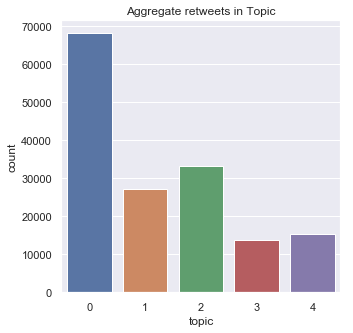

In [166]:

import seaborn as sns
import matplotlib.pyplot as plt
figure = plt.figure(figsize = (5, 5))
sns.set(style="darkgrid")

ax = sns.countplot(x='topic', data=r2)
plt.title('Aggregate retweets in Topic')

In [167]:
figure.savefig('../media/agg_retweet_topic.png')

In [168]:
r2.to_csv('../data_collection/data/user_tweet_topic.csv')

In [170]:
#counting the number of articles a user has retweeted under each topic
D = {}
for i in range(r2.shape[0]): 
    topic = r2.topic[i]
    user = r2.user_id[i]
    
    if not user in D: 
        D[user] = {0:0, 1:0, 2:0, 3:0, 4:0} 
        D[user][topic] += 1
    else: 
        D[user][topic] += 1
        

In [171]:
#creating the data frame for the topic count for each user
r3 = pd.DataFrame(D).T
r3.reset_index(inplace = True)
r3.head()

,index,0,1,2,3,4
0,55651793,7,5,2,3,1
1,191972027,4,2,1,0,1
2,22681390,1,1,1,1,0
3,897359310308622336,1,1,0,0,0
4,4141824748,35,17,9,7,4


In [172]:
r3.rename(columns={'index': 'user_id'}, inplace = True)
r3.head(2)

,user_id,0,1,2,3,4
0,55651793,7,5,2,3,1
1,191972027,4,2,1,0,1


In [173]:
unique_users =  pd.read_csv('../data_collection/data/unique_users.csv')
unique_users.drop('Unnamed: 0', axis =1 , inplace =True)
unique_users.head(2)

,user_id,screen_name,location,retweet_list,retweet_count
0,55651793,['JSullivanIII'],"['Queens, NYC']","[1097372619848986625, 1096157615225212933, 109...",18
1,191972027,['ojessen'],['Kiel'],"[1097372619848986625, 1096696739128578048, 109...",8


In [174]:
r3.shape, unique_users.shape

((76913, 6), (76913, 5))

In [175]:
#Merging the topic distribution for each user with the unique users dataframe
r4 = pd.merge(unique_users, r3, how = 'inner', on = ['user_id'] )
print(r4.shape)
r4.head(2)

(76913, 10)


,user_id,screen_name,location,retweet_list,retweet_count,0,1,2,3,4
0,55651793,['JSullivanIII'],"['Queens, NYC']","[1097372619848986625, 1096157615225212933, 109...",18,7,5,2,3,1
1,191972027,['ojessen'],['Kiel'],"[1097372619848986625, 1096696739128578048, 109...",8,4,2,1,0,1


In [176]:
# r4.to_csv('../data_collection/data/unique_user_topic_distribution.csv')

In [177]:
r2.head(2)

,user_id,screen_name,location,tweet_id,topic,rating
0,55651793,JSullivanIII,"Queens, NYC",1097372619848986625,1,1.0
1,191972027,ojessen,Kiel,1097372619848986625,1,1.0


In [178]:
a.head(2)

,tweet_id,text,top_image,title,authors,summary,keywords,cleaned_text,topic,count
0,1097372619848986625,A kindergarten boy’s behavior could predict hi...,https://static01.nyt.com/images/2016/09/14/wel...,Behavior at Age 6 May Predict Adult Income,['Nicholas Bakalar'],A kindergarten boy’s behavior could predict hi...,"['boys', 'income', 'inattention', 'age', 'beha...","[kindergarten, boy, behavior, could, predict, ...",1,2
1,1097368941842837506,"In more than 14 years of roaming Mars, NASA’s ...",https://static01.nyt.com/images/2019/02/15/sci...,Photos From the Opportunity Rover’s Mission on...,['Kenneth Chang'],"In more than 14 years of roaming Mars, NASA’s ...","['mission', 'rovers', 'mars', 'opportunity', '...","[roam, mar, nasa, opportunity, rover, take, pi...",3,2


In [179]:
#creating a data frame for the number of retweeters for each article
topic_count = r2.groupby('tweet_id').count()
topic_count.drop(['user_id', 'screen_name', 'rating', 'location'], axis=1, inplace = True)
topic_count.reset_index(inplace = True)
topic_count.rename(columns = {'topic': 'retweet_count'}, inplace = True)
topic_count.head()

,tweet_id,retweet_count
0,1086277077685301249,89
1,1086284595207778305,92
2,1086292173996339200,75
3,1086295933300674562,86
4,1086299729565270016,91


In [180]:
#adding the above information to our over all data frame
a = pd.merge(a, topic_count, how = 'inner', on = ['tweet_id'])
print(a.shape)
a.head()

(2434, 11)


,tweet_id,text,top_image,title,authors,summary,keywords,cleaned_text,topic,count,retweet_count
0,1097372619848986625,A kindergarten boy’s behavior could predict hi...,https://static01.nyt.com/images/2016/09/14/wel...,Behavior at Age 6 May Predict Adult Income,['Nicholas Bakalar'],A kindergarten boy’s behavior could predict hi...,"['boys', 'income', 'inattention', 'age', 'beha...","[kindergarten, boy, behavior, could, predict, ...",1,2,37
1,1097368941842837506,"In more than 14 years of roaming Mars, NASA’s ...",https://static01.nyt.com/images/2019/02/15/sci...,Photos From the Opportunity Rover’s Mission on...,['Kenneth Chang'],"In more than 14 years of roaming Mars, NASA’s ...","['mission', 'rovers', 'mars', 'opportunity', '...","[roam, mar, nasa, opportunity, rover, take, pi...",3,2,89
2,1097364848890007552,Studies show that at a normal body weight — ge...,https://static01.nyt.com/images/2019/02/19/wel...,Why Do South Asians Have Such High Rates of He...,['Anahad O Connor'],Heart risks tended to be greatest in South Asi...,"['masala', 'disease', 'rates', 'high', 'health...","[study, show, normal, body, weight, generally,...",0,4,82
3,1097359831034486785,"For Elisa, interviewing Hays has been a frustr...",https://static01.nyt.com/images/2019/02/18/art...,"‘True Detective’ Season 3, Episode 7: Missing ...",['Scott Tobias'],The one-eyed man whom they had originally ques...,"['true', 'discover', 'missing', 'lucy', '1990'...","[elisa, interview, hay, frustrate, act, excava...",0,4,31
4,1097355297138581507,The hiring went off like a sonic boom in Holly...,https://static01.nyt.com/images/2019/02/18/bus...,"In Bid to Conquer Oscars, Netflix Mobilizes Sa...",['Brooks Barnes'],“Awards Landscape Rocked as Netflix Poaches Le...,"['savvy', 'studios', 'conquer', 'roma', 'holly...","[hire, sonic, boom, hollywood, reverberate, hi...",2,2,53


In [181]:
# a.to_csv('../data_collection/data/art_info_w_topic.csv')

In [183]:

#extracting the topic probability distribution for each article 
num_topics = 5
article_topics = {}
retweet_count = {}

for i in range(len(a)):
    doc = a["cleaned_text"][i]
    #doc_dict = gensim.corpora.Dictionary([doc])
    doc_corp = doc_dict.doc2bow(doc)

    doc_prob = lda_model[doc_corp]
    
    topic_prob = [0 for i in range(num_topics)]
    for prob in doc_prob:
        topic_prob[prob[0]] = prob[1] 
        
    article_topics[a["tweet_id"][i]] = topic_prob
    retweet_count[a["tweet_id"][i]] = a['retweet_count'][i]
    
    


In [184]:
article_topics[1097372619848986625]

[0, 0.4480056, 0.5470507, 0, 0]

In [185]:
retweet_count[1097372619848986625]

37

In [186]:
top_dist = pd.DataFrame()
top_dist['tweet_id'] = a.tweet_id
top_dist['topic_0'] = [article_topics[i][0] for i in a.tweet_id]
top_dist['topic_1'] = [article_topics[i][1] for i in a.tweet_id]
top_dist['topic_2'] = [article_topics[i][2] for i in a.tweet_id]
top_dist['topic_3'] = [article_topics[i][3] for i in a.tweet_id]
top_dist['topic_4'] = [article_topics[i][4] for i in a.tweet_id]
print(top_dist.shape)
top_dist.head()

(2434, 6)


,tweet_id,topic_0,topic_1,topic_2,topic_3,topic_4
0,1097372619848986625,0.000000,0.448006,0.547051,0.000000,0.000000
1,1097368941842837506,0.000000,0.000000,0.000000,0.580206,0.410655
2,1097364848890007552,0.349411,0.027401,0.238046,0.000000,0.384532
3,1097359831034486785,0.016955,0.835108,0.124532,0.022292,0.000000
4,1097355297138581507,0.000000,0.000000,0.194885,0.000000,0.802128


In [187]:
# top_dist.to_csv('../data_collection/data/art_topic_distribution.csv')